In [82]:
require(data.table)
require(glmnet)
require(ggplot2)
set.seed(123)
###reading data
housingData=fread('./kc_house_data.csv/kc_house_data.csv')

##Removing non numeric var
housingData[,floors:=as.numeric(floors)][,c('zipcode','lat','long','id','date','sqft_basement'):=NULL]
 
###Splitting data
indexTrain=sample.int(nrow(housingData),nrow(housingData)*0.75)
 
 


Warning message in require_bit64():
"Some columns are type 'integer64' but package bit64 is not installed. Those columns will print as strange looking floating point data. There is no need to reload the data. Simply install.packages('bit64') to obtain the integer64 print method and print the data again."

In [83]:
##no Reg
lmNoReg=lm(price~.,housingData[indexTrain])
summary(lmNoReg)
pred_no_reg=predict(lmNoReg,housingData[-indexTrain])
 
sqrt(mean((pred_no_reg-housingData[-indexTrain]$price)^2))
 
 
plotCoeffEvolution=function(penalizedGlm,type='L1')
{
 require(ggplot2)
 lambda=penalizedGlm$lambda
 coeff=as.matrix(penalizedGlm$beta)
 rowName=rownames(coeff)
 coeff=data.table(coeff)
 coeff[,name:=rowName]
 coeff=melt(coeff,id.vars = 'name')
 coeff[,variable:=rep(lambda,each=length(unique(name)))]
 ggplot(coeff,aes(x=variable,y=value,color=name))+geom_line()+xlab(paste0(type,' regularisation'))+ylab('Value of coefficient')+scale_x_log10()+theme(legend.position="top")
}
 




Call:
lm(formula = price ~ ., data = housingData[indexTrain])

Residuals:
     Min       1Q   Median       3Q      Max 
-1279695  -110392    -9815    90351  4208139 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.112e+06  1.634e+05  37.398  < 2e-16 ***
bedrooms      -4.150e+04  2.362e+03 -17.566  < 2e-16 ***
bathrooms      4.668e+04  4.104e+03  11.373  < 2e-16 ***
sqft_living    1.741e+02  5.503e+00  31.640  < 2e-16 ***
sqft_lot      -3.080e-02  6.138e-02  -0.502   0.6158    
floors         2.230e+04  4.448e+03   5.013 5.43e-07 ***
waterfront     5.529e+05  2.149e+04  25.735  < 2e-16 ***
view           4.454e+04  2.656e+03  16.774  < 2e-16 ***
condition      1.857e+04  2.944e+03   6.310 2.87e-10 ***
grade          1.165e+05  2.648e+03  43.986  < 2e-16 ***
sqft_above    -6.183e-01  5.364e+00  -0.115   0.9082    
yr_built      -3.516e+03  8.384e+01 -41.936  < 2e-16 ***
yr_renovated   1.109e+01  4.566e+00   2.429   0.0151 *  
sqft_living15  2.140

[1] 204758.7

Loading required package: plotly
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'plotly'"

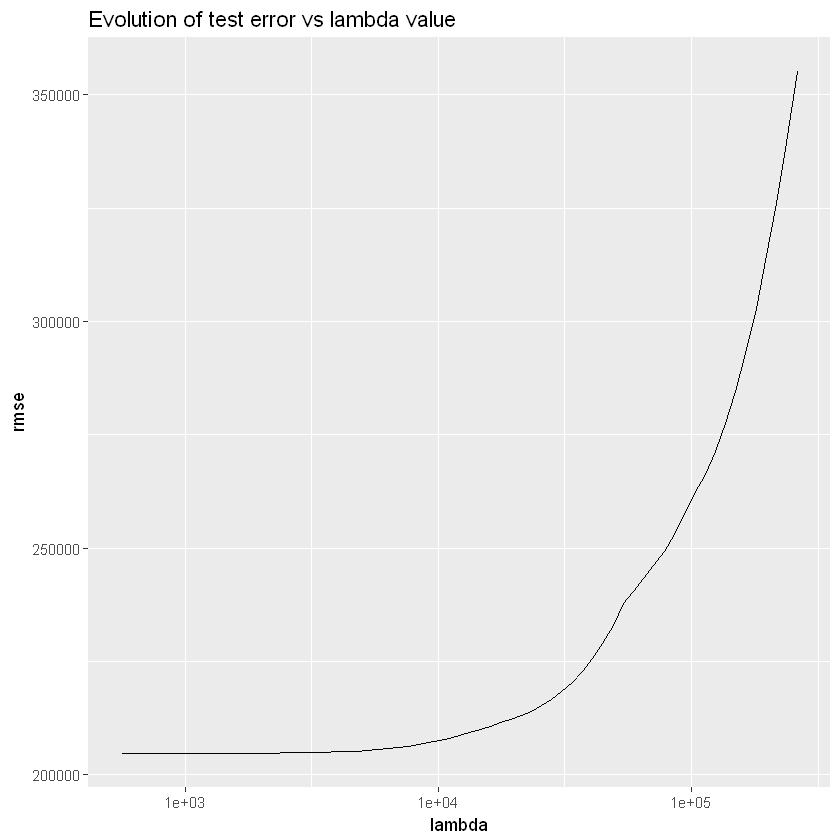

In [84]:
##Different L1 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=1)
 
pred_L1_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1=sqrt(apply(pred_L1_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L1)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()
require(plotly)
 

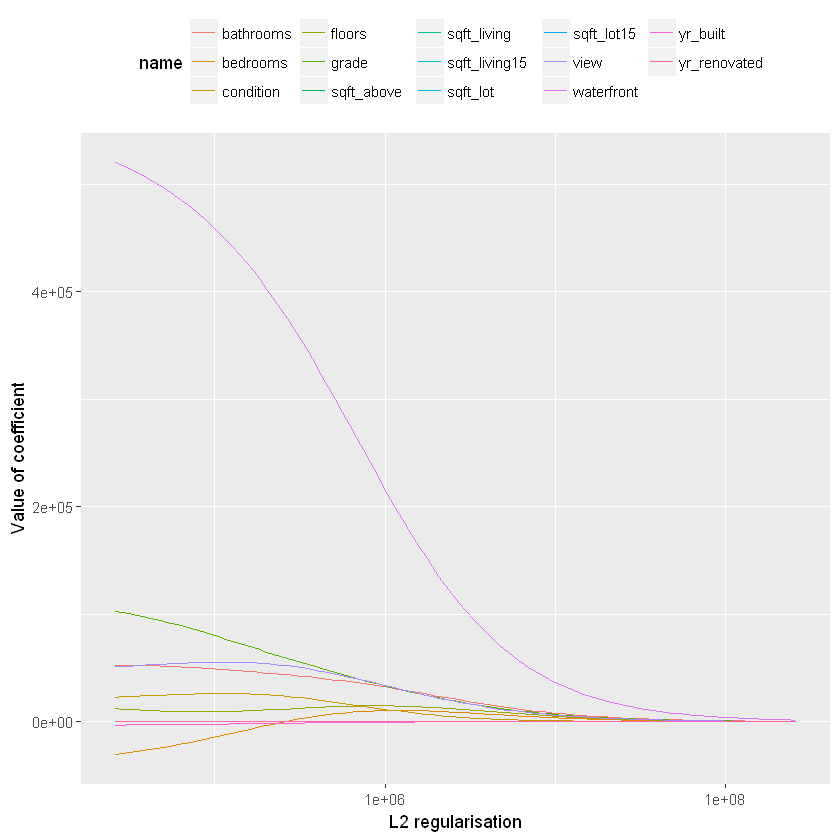

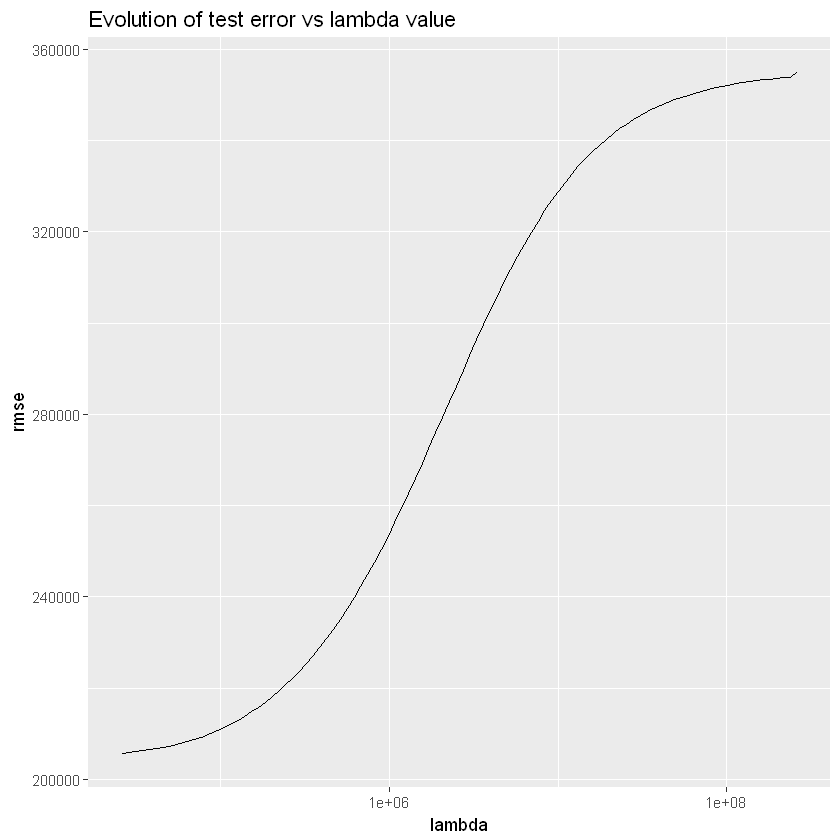

In [85]:
## L2 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=0.0)
 
pred_L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L2=sqrt(apply(pred_L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L2_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L2)
plotCoeffEvolution(fit,'L2')
require(ggplot2)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()

 


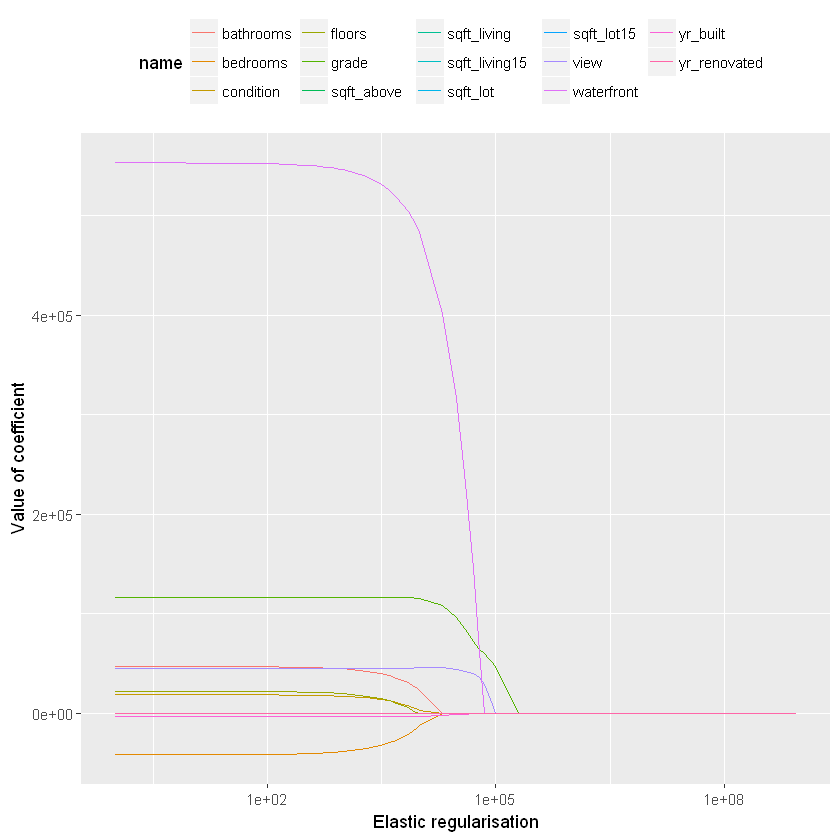

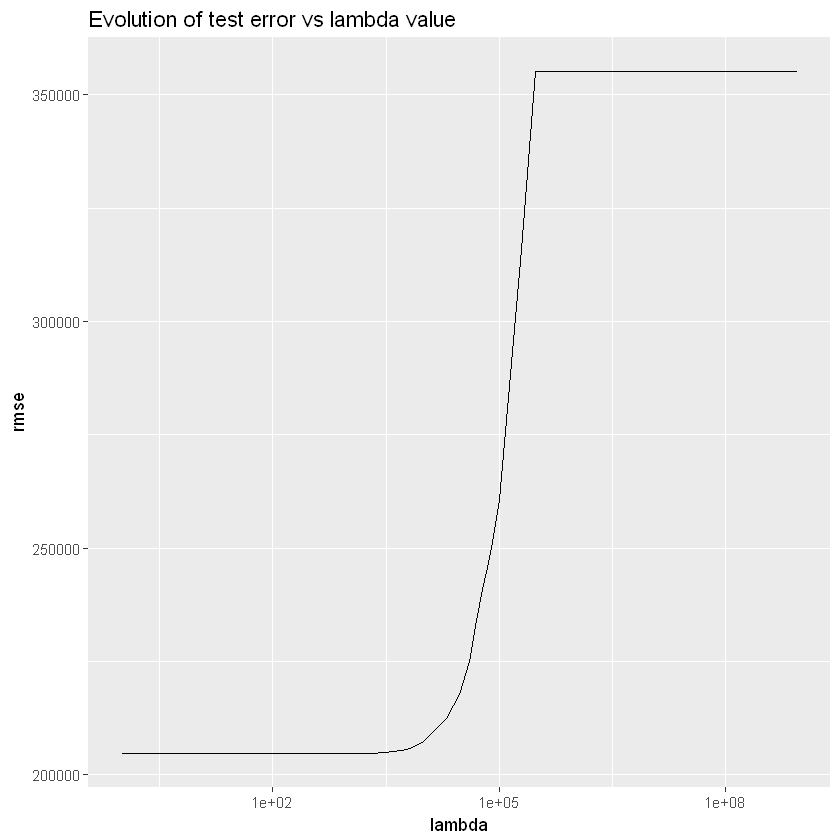

In [91]:
## L1 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=1, lambda=ll)
 
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L1L2)
plotCoeffEvolution(fit,'Elastic')
require(ggplot2)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()

In [73]:
pred<-predict(fit,newx=as.matrix(housingData[,-1]),type='response',s=1E-5)
truth<-as.matrix(housingData[,1])

In [74]:
data<-data.frame(pred,truth)

Don't know how to automatically pick scale for object of type data.frame. Defaulting to continuous.
Don't know how to automatically pick scale for object of type data.frame. Defaulting to continuous.


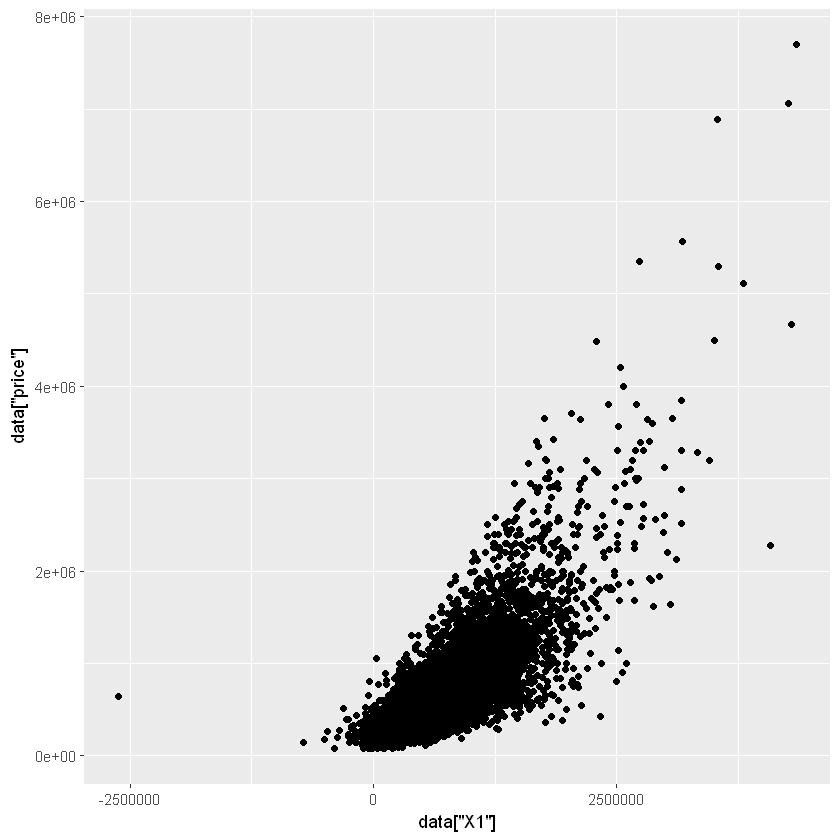

In [75]:
ggplot(data,aes(x=data['X1'],y=data['price']))+geom_point()

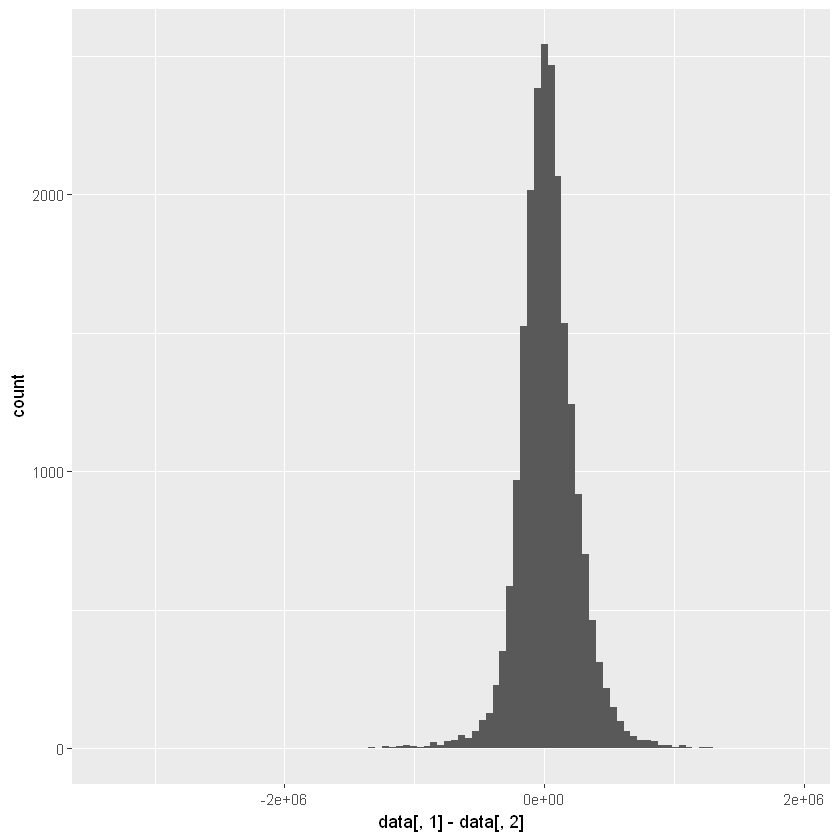

In [76]:
ggplot(data, aes(data[,1]-data[,2])) + geom_histogram(bins=100)


In [77]:
min(RMSE_L1L2)

[1] 229747

In [78]:
value=1E12
alpha=0
for (i in 0:100){
var=i/100
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=var)
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
temp<-min(RMSE_L1L2)
if (temp < value){
    value<-temp
    alpha=var}
}

In [79]:
value

[1] 227254.3

In [80]:
alpha

[1] 0.05

In [97]:
vals<-0:100
vals=vals/100


In [98]:
min_loss<-function (var){
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=var)
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
temp<-min(RMSE_L1L2)
    return(temp)
}

In [99]:
loss<-sapply(vals, min_loss)

In [100]:
loss

[1] 205702.5 204739.9 204737.9 204736.9 204735.6 204734.5 204733.2 204732.1
  [9] 204731.0 204729.9 204728.9 204727.8 204726.8 204725.9 204725.0 204724.2
 [17] 204723.4 204722.6 204721.7 204721.2 204720.4 204719.7 204719.2 204718.6
 [25] 204718.3 204717.7 204717.2 204716.9 204716.6 204716.3 204715.9 204715.8
 [33] 204715.5 204715.7 204715.6 204715.4 204715.3 204715.3 204715.2 204715.1
 [41] 204715.1 204714.9 204714.9 204714.9 204715.0 204714.9 204715.0 204715.1
 [49] 204717.2 204715.2 204717.0 204719.4 204719.4 204717.2 204717.1 204717.1
 [57] 204717.0 204716.7 204720.2 204720.3 204720.2 204720.2 204720.5 204720.4
 [65] 204720.6 204723.2 204724.1 204722.9 204723.7 204724.4 204725.1 204725.8
 [73] 204726.5 204727.1 204727.8 204728.4 204729.0 204729.6 204730.2 204730.8
 [81] 204731.3 204731.9 204732.4 204733.0 204733.5 204734.0 204734.4 204734.9
 [89] 204735.3 204735.8 204738.7 204736.6 204737.0 204737.4 204740.4 204740.8
 [97] 204741.1 204741.5 204741.8 204742.2 204742.5

In [101]:
min(loss)

[1] 204714.9

In [ ]:
##Different L1L2 regularisation
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=0.45,lambda=ll)
 
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
DF_plot=data.frame(lambda=fit$lambda,rmse=RMSE_L1L2)
plotCoeffEvolution(fit,'Elastic')
require(ggplot2)
ggplot(DF_plot,aes(x=lambda,y=rmse))+geom_line()+ggtitle("Evolution of test error vs lambda value")+scale_x_log10()+ geom_vline(xintercept=14000)

In [81]:
fit = glmnet(as.matrix(housingData[indexTrain,-c('price'),with=F]),as.matrix(housingData[indexTrain]$price) , family="gaussian",alpha=0.05)
pred_L1L2_reg=data.table(predict(fit,as.matrix(housingData[-indexTrain,-c('price'),with=F])))
RMSE_L1L2=sqrt(apply(pred_L1L2_reg[,(.SD-housingData[-indexTrain]$price)^2,.SD=1:ncol(pred_L1L2_reg)],2,mean))
DF_plot[DF_plot$rmse==min(DF_plot$rmse),]

,lambda,rmse
s30,22394.87,229747


In [87]:
l1=1:9

In [88]:
l2=l1*10
l3=l1*100
l4=l1*1000
l5=l1*10000
l6=l1*100000
l7=l1*1000000
l8=l1*10000000
l9=l1*100000000

In [89]:
ll=c(l1,l2,l3,l4,l5,l6,l7,l8,l9)

In [90]:
ll

[1] 1e+00 2e+00 3e+00 4e+00 5e+00 6e+00 7e+00 8e+00 9e+00 1e+01 2e+01 3e+01
[13] 4e+01 5e+01 6e+01 7e+01 8e+01 9e+01 1e+02 2e+02 3e+02 4e+02 5e+02 6e+02
[25] 7e+02 8e+02 9e+02 1e+03 2e+03 3e+03 4e+03 5e+03 6e+03 7e+03 8e+03 9e+03
[37] 1e+04 2e+04 3e+04 4e+04 5e+04 6e+04 7e+04 8e+04 9e+04 1e+05 2e+05 3e+05
[49] 4e+05 5e+05 6e+05 7e+05 8e+05 9e+05 1e+06 2e+06 3e+06 4e+06 5e+06 6e+06
[61] 7e+06 8e+06 9e+06 1e+07 2e+07 3e+07 4e+07 5e+07 6e+07 7e+07 8e+07 9e+07
[73] 1e+08 2e+08 3e+08 4e+08 5e+08 6e+08 7e+08 8e+08 9e+08